In [41]:
using Random, Distributions
using Plots
using DataFrames
using StatsBase
using DelimitedFiles
using LinearAlgebra
# using Distances
# using Symbolics
# using Latexify
# using LsqFit
# using Clustering
using Findpeaks

# Problem Set 7 (Jonathan Fischer using Julia)

## 1) Describe the model

### a) 

In [42]:
println("mRNA_A
geneA
mRNA_R
A
geneA_bound
R
geneR
geneR_bound
C")

mRNA_A
geneA
mRNA_R
A
geneA_bound
R
geneR
geneR_bound
C


### b)

In [43]:
println("16 total reactions, because two reactions are reversible")

16 total reactions, because two reactions are reversible


### c)

In [44]:
println("Reactions 11 - 14 involve degradation")

Reactions 11 - 14 involve degradation


### d)

In [45]:
println("Bimolecular reactions: 
                    2a
                    5a
                    9, with the fastest rate constant. The rate itself is of course time dependent ")

Bimolecular reactions: 
                    2a
                    5a
                    9, with the fastest rate constant. The rate itself is of course time dependent 


### e)

In [46]:
println("Gene A exists in either a bound or unbound state. When unbound, it can be bound by the protein A to transition to a bound state, as well as the reverse reaction back to the unbound state")

Gene A exists in either a bound or unbound state. When unbound, it can be bound by the protein A to transition to a bound state, as well as the reverse reaction back to the unbound state


### f)

In [47]:
println("Gene A is transcibed most frequently, when comparing reactions 1 and 3 to 4 and 6")

Gene A is transcibed most frequently, when comparing reactions 1 and 3 to 4 and 6


### g)

In [20]:
println("mRNA_A is translated most frequently, 10x faster for a given copy number than mRNA_R")

mRNA_A is translated most frequently, 10x faster for a given copy number than mRNA_R


### h)

In [48]:
println("mRNA_A degrades most frequently")

mRNA_A degrades most frequently


## 2) Simulate the model

In [49]:
function gillespie_alg(model, u0, tend, p, stoich; tstart=zero(tend))
    t = tstart   # Current time
    ts = [t]     # Time points
    u = copy(u0) # Current state
    us = copy(u) # Record of states
    counter = 0
    while t < tend
        a = model(u, p)               # propensities
        dt = randexp() / sum(a)          # Time step
        du = sample(stoich, Weights(a))  # Choose the stoichiometry for the next reaction
        
        u .+= du  # Update state
        t += dt   # Update time
        counter += 1
        
        # us = [us u]  # Append state variable to record
        # push!(ts, t) # Append time point to record
        if mod(counter,10) == 0
            us = [us u]  # Append state variable to record
            push!(ts, t) # Append time point to record
        end
    end
    # Make column as variables, rows as observations
    us = collect(us')
    return (t = ts, u = us)
end

gillespie_alg (generic function with 1 method)

In [50]:
#geneA, geneR, mRNA_A, mRNA_R, geneA_bound, geneR_bound, A, R, C 
ydict = Dict(:geneA => 1, :geneR => 1, :mRNA_A => 0, :mRNA_R => 0, :geneA_bound => 0, :geneR_bound => 0, :A => 0, :R => 0, :C => 0)

Dict{Symbol, Int64} with 9 entries:
  :mRNA_A      => 0
  :geneA       => 1
  :mRNA_R      => 0
  :A           => 0
  :geneA_bound => 0
  :R           => 0
  :geneR       => 1
  :geneR_bound => 0
  :C           => 0

In [51]:
function makestoich(reactants, products) #function to make stoichiometry vector for given reaction 
    stoich = zeros(Int,9)
    for r in reactants 
        for (i,d) in enumerate(keys(ydict)) 
            if d == r 
                stoich[i] += -1 
            end
        end
    end
    for p in products
        for (j,d) in enumerate(keys(ydict))
            if d == p
                stoich[j] += 1 
            end
        end
    end
    return stoich 
end

makestoich (generic function with 1 method)

In [52]:
function convertrate(rate; volume = 4.189) #convert bimolecular rate constant to copy numbers 
    volume2 = volume/1e15 #converts to liters 
    rate2 = rate/volume2 #get per micromoles per hour
    rate2/(6.023e17) #get per copies per hour 
end

convertrate (generic function with 1 method)

In [53]:
"Propensity model using copy numbers"
model(y, c) = [c.kf1 * y[2],  c.kf2 * y[2] * y[4], c.kb2 * y[5], c.kf3 * y[5],
            c.kf4 * y[7], c.kf5 * y[7]*y[4], c.kb5 * y[8], c.kf6 * y[8], c.kf7 * y[1], 
            c.kf8 * y[3], c.kf9 * y[4]*y[6], c.kf10 * y[9], c.kf11 * y[4], c.kf12 * y[6], c.kf13 * y[1], c.kf14*y[3]]

parameters = (kf1=50.0, kf2=convertrate(602.), kb2 = 50., kf3 = 500., kf4 = 0.01, kf5 = convertrate(602.), kb5 = 100., kf6 = 50., kf7 = 50., kf8 = 5., kf9 = convertrate(1204.), kf10 = 1., kf11 = 1., kf12 = 0.2, kf13 = 10., kf14 = 0.5, stoich=[makestoich([:geneA],[:geneA,:mRNA_A]), makestoich([:geneA,:A],[:geneA_bound]), makestoich([:geneA_bound],[:geneA,:A]), makestoich([:geneA_bound],[:geneA_bound,:mRNA_A]), makestoich([:geneR],[:geneR,:mRNA_R]), makestoich([:geneR,:A],[:geneR_bound]), makestoich([:geneR_bound],[:geneR,:A]), makestoich([:geneR_bound],[:geneR_bound, :mRNA_R]), makestoich([:mRNA_A],[:mRNA_A,:A]), makestoich([:mRNA_R],[:mRNA_R,:R]), makestoich([:A,:R],[:C]), makestoich([:C],[:R]), makestoich([:A],[]), makestoich([:R],[]), makestoich([:mRNA_A],[]), makestoich([:mRNA_R],[])])

tend = 200.0

200.0

In [54]:
y0 = collect(values(ydict))

plot_array = Any[] # can type this more strictly
for i in 1:5
    gil_sol = gillespie_alg(model, y0, tend, parameters, parameters.stoich)
    subplt = plot(gil_sol.t,gil_sol.u[:,4], label = "A")
    plot!(gil_sol.t,gil_sol.u[:,6], label = "R")
    push!(plot_array,subplt) # make a plot and add it to the plot_array
end

In [55]:
fiveplot = plot(plot_array..., size = (1000,700))
xlabel!("t (hours)")
ylabel!("Species copy numbers")
savefig("prob2a.png")
display(fiveplot)

In [22]:
println("A peaks first, which makes sense given its gene is transcribed most frequently and its mRNA translated most frequently")

A peaks first, which makes sense given its gene is transcribed most frequently and its mRNA translated most frequently


### b) Peak height

In [56]:
function get_avgpeak(sol)
    Apeaks = findpeaks(sol.u[:,4],sol.t, min_prom= 1000, min_dist= 10.)
    Rpeaks = findpeaks(sol.u[:,6],sol.t, min_prom= 1000, min_dist= 10.)

    println("Mean peak height for A: $(mean([sol.u[x,4] for x in Apeaks])) copies")
    println("Mean peak height for R: $(mean([sol.u[x,6] for x in Rpeaks])) copies")
end

get_avgpeak (generic function with 1 method)

In [57]:
gil_sol = gillespie_alg(model, y0, tend, parameters, parameters.stoich)

get_avgpeak(gil_sol)

Mean peak height for A: 1325.0 copies
Mean peak height for R: 1302.75 copies


### c) Average wavelength

In [58]:
"Function to get the time differences between peaks, AKA wavelengths"

function get_tdiffs(peaktimes)
    tdiffs = []
    for i in 1:length(peaktimes)-1
        push!(tdiffs, peaktimes[i+1]-peaktimes[i])
    end
    return tdiffs 
end

get_tdiffs (generic function with 1 method)

In [61]:
"Function to get average wavelength"

function get_avgwavelength(sol) 
    Apeaks = findpeaks(sol.u[:,4],sol.t, min_prom= 1000, min_dist= 10.) #get indices of peaks 
    Rpeaks = findpeaks(sol.u[:,6],sol.t, min_prom= 1000, min_dist= 10.)

    Atimes = sort([sol.t[x] for x in Apeaks]) #get vector of peak times 
    Rtimes = sort([sol.t[x] for x in Rpeaks])

    Atimediffs = get_tdiffs(Atimes) #get vector of differences in peaks in hours
    Rtimediffs = get_tdiffs(Rtimes)

    println("Mean wavelength for A: $(mean(Atimediffs)*3600) s") #print mean wavelength in seconds 
    println("Mean wavelength for R: $(mean(Rtimediffs)*3600) s")
end

get_avgwavelength (generic function with 1 method)

In [62]:
"Average wavelengths in seconds. Instructions said seconds, not hours, not sure if typo"

get_avgwavelength(gil_sol)

Mean wavelength for A: 89285.33931937077 s
Mean wavelength for R: 89499.96479999289 s


### d) Decreased R degredation rate 

In [63]:
"Propensity model using copy numbers with reduced R degradation rate"
model(y, c) = [c.kf1 * y[2],  c.kf2 * y[2] * y[4], c.kb2 * y[5], c.kf3 * y[5],
            c.kf4 * y[7], c.kf5 * y[7]*y[4], c.kb5 * y[8], c.kf6 * y[8], c.kf7 * y[1], 
            c.kf8 * y[3], c.kf9 * y[4]*y[6], c.kf10 * y[9], c.kf11 * y[4], c.kf12 * y[6], c.kf13 * y[1], c.kf14*y[3]]

parameters = (kf1=50.0, kf2=convertrate(602.), kb2 = 50., kf3 = 500., kf4 = 0.01, kf5 = convertrate(602.), kb5 = 100., kf6 = 50., kf7 = 50., kf8 = 5., kf9 = convertrate(1204.), kf10 = 1., kf11 = 1., kf12 = 0.2, kf13 = 10., kf14 = 0.5, stoich=[makestoich([:geneA],[:geneA,:mRNA_A]), makestoich([:geneA,:A],[:geneA_bound]), makestoich([:geneA_bound],[:geneA,:A]), makestoich([:geneA_bound],[:geneA_bound,:mRNA_A]), makestoich([:geneR],[:geneR,:mRNA_R]), makestoich([:geneR,:A],[:geneR_bound]), makestoich([:geneR_bound],[:geneR,:A]), makestoich([:geneR_bound],[:geneR_bound, :mRNA_R]), makestoich([:mRNA_A],[:mRNA_A,:A]), makestoich([:mRNA_R],[:mRNA_R,:R]), makestoich([:A,:R],[:C]), makestoich([:C],[:R]), makestoich([:A],[]), makestoich([:R],[]), makestoich([:mRNA_A],[]), makestoich([:mRNA_R],[])])
# y0 = [180, 360]
tend = 200.0

200.0

In [64]:
gil_sol2 = gillespie_alg(model, y0, tend, parameters, parameters.stoich)

(t = [0.0, 0.03221404626141072, 0.052873424501947194, 0.07055279996688509, 0.08711978972283475, 0.10931363924255635, 0.13408417168977033, 0.15578977965853297, 0.16292821359772255, 0.17908921967709285  …  199.94567345395654, 199.95309643276985, 199.95766979532038, 199.9612862447778, 199.96330048190057, 199.965983034583, 199.97290317149978, 199.97885181967334, 199.98569180168536, 199.99036554216562], u = [0 1 … 0 0; 6 1 … 0 0; … ; 8 1 … 0 525; 7 1 … 0 525])

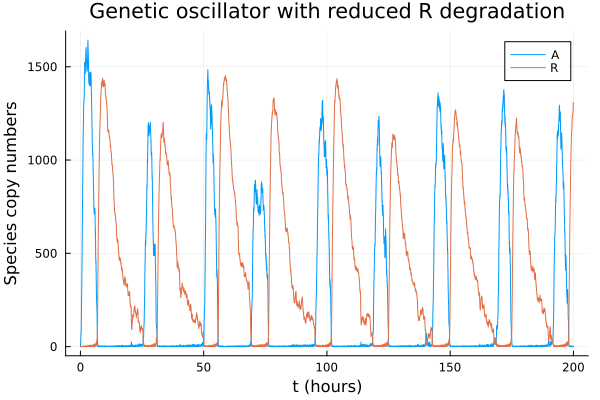

In [65]:
gil_plot2 = plot(gil_sol2.t,gil_sol2.u[:,4], label = "A")
plot!(gil_sol2.t,gil_sol2.u[:,6], label = "R")
xlabel!("t (hours)")
ylabel!("Species copy numbers")
title!("Genetic oscillator with reduced R degradation")
savefig("prob2d.png")
display(gil_plot2)

In [40]:
println("They remain the same because all state variables must be integer values for SSA. Presumably, the steady state value 
            that would be seen in the deterministic solution is a non-integer value")

They remain the same because all state variables must be integer values for SSA. Presumably, the steady state value 
            that would be seen in the deterministic solution is a non-integer value


## 3) Chemical kinetics and rate equations 

a) d[B]/dt = -k1[A][B] - 2k4[B][B] + k5[D]

b) d[C]/dt = k1[A][B] - k3[C] - k6[C][D]

c) d[D]/dt = k4[B][B] - k5[D] + k6[C][D]